In [2]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor
from allensdk.api.queries.cell_types_api import CellTypesApi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Set up data directory
os.makedirs('cell_types', exist_ok=True)
manifest_path = './cell_types/manifest.json'
ctc = CellTypesCache(manifest_file=manifest_path)


In [3]:
specimens = ctc.get_cells(species=[CellTypesApi.HUMAN])
print(f"Total human cells available: {len(specimens)}")



Total human cells available: 413


In [6]:
from tqdm import tqdm

results = []

for cell in tqdm(specimens):
    try:
        specimen_id = cell['id']
        data_set = ctc.get_ephys_data(specimen_id)
        sweeps = ctc.get_ephys_sweeps(specimen_id)
        
        for sweep in sweeps:
            if sweep.get('stimulus_units') == 'Amps':
                sweep_number = sweep['sweep_number']
                sweep_data = data_set.get_sweep(sweep_number)

                stim = sweep_data['stimulus'] * 1e12  # to pA
                stim_amp = np.max(stim) - np.min(stim)  # estimate amplitude
                if stim_amp < 10:  # ignore empty traces
                    continue
                sweep_number = sweep['sweep_number']
                sweep_data = data_set.get_sweep(sweep_number)
                
                v = sweep_data['response'] * 1000     # Volts to mV
                i = sweep_data['stimulus'] * 1e12     # Amps to pA
                t = np.arange(0, len(v)) / sweep_data['sampling_rate']
                
                extractor = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.0, end=2.0)
                extractor.process_spikes()
                spike_times = extractor.spike_feature("threshold_t")
                
                results.append({
                    'specimen_id': specimen_id,
                    'sweep_number': sweep_number,
                    'stimulus_amplitude_pA': stim_amp * 1e12,
                    'num_spikes': len(spike_times)
                })
    except Exception as e:
        print(f"Error processing specimen {specimen_id}: {e}")
        continue


100%|██████████| 413/413 [26:21<00:00,  3.83s/it]


In [10]:
df = pd.DataFrame(results)
print(f"Total valid sweeps: {len(df)}")
df.head()


Total valid sweeps: 25197


,specimen_id,sweep_number,stimulus_amplitude_pA,num_spikes
0,525011903,4,8.000000e+14,0
1,525011903,5,8.000000e+14,0
2,525011903,6,8.000000e+14,0
3,525011903,7,1.000000e+14,0
4,525011903,8,2.000000e+14,0


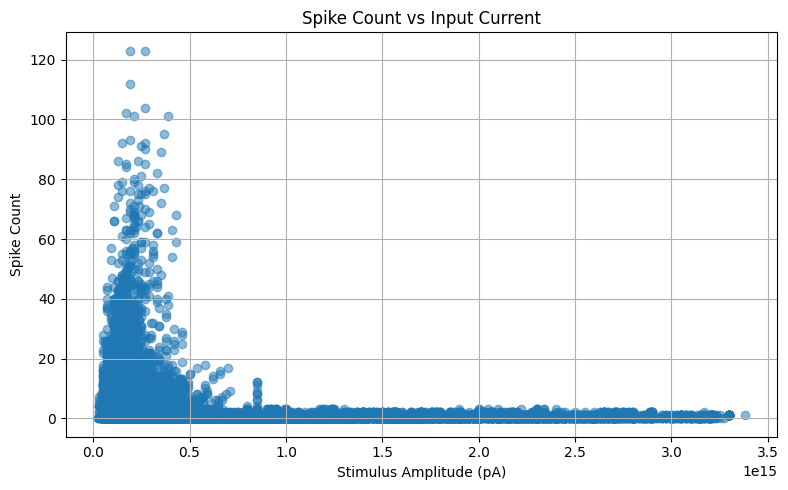

In [14]:
plt.figure(figsize=(8, 5))
plt.scatter(df['stimulus_amplitude_pA'], df['num_spikes'], alpha=0.5)
plt.xlabel("Stimulus Amplitude (pA)")
plt.ylabel("Spike Count")
plt.title("Spike Count vs Input Current")
plt.grid(True)
plt.tight_layout()
plt.savefig('../spike_count_vs_current.png', dpi=300)
plt.show()


In [20]:
# Save the cleaned dataset for model training
df.to_csv('../mtg_spikecount_dataset.csv', index=False)
print("Saved cleaned dataset to ../mtg_spikecount_dataset.csv")


Saved cleaned dataset to ../mtg_spikecount_dataset.csv
